In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Survey of cell-free transcription-translation models
May 2020, Nadanai Laohakunakorn 

*Please report any errors you spot to nadanai.laohakunakorn@ed.ac.uk*


Here I give a brief introduction to different cell-free models available in the literature, and present examples of how to simulate them. I implement them all in the same format (which may look different to the original implementation) in order to highlight their features.

### 1. Constitutive coupled transcription/translation

This is the simplest possible model which contains both transcription and translation. Transcription proceeds at a constant rate $k_1$ to produce mRNA $m$, and translation is linearly proportional to the concentration of $m$ present. The protein is represented by $p$. The implementation involves defining a gradient function which encodes the derivatives to be solved; this is then passed into the ODE solver, along with parameters and initial conditions. For the basic models the parameters are dimensionless. Parameters with physical values may be approximated, obtained from the literature, or directly inferred from experiments (for instance, by fitting the model predictions to experimental time-course and titration data).

*Mechanism*

\begin{equation}
\emptyset \overset{k_1}\rightarrow m
\end{equation}
\begin{equation}
m \overset{k_a}\rightarrow p
\end{equation}

*ODEs*

\begin{align}
\dot{m} &= k_1 \\
\dot{p} &= k_a m
\end{align}

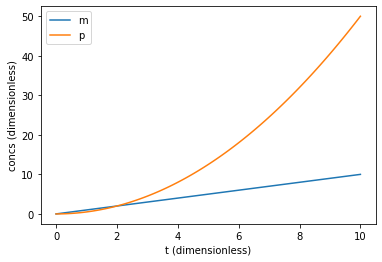

In [2]:
# Implementation

# Define the model's gradient function
def M1(y, t, params):
    m = y[0]
    p = y[1]
    
    k1 = params[0]
    ka = params[1]
   
    derivs = [
        k1,
        ka*m
    ]
    return(derivs)

# Set initial conditions 
m0 = 0.0
p0 = 0.0

# Set parameters
k1 = 1.0
ka = 1.0

# Solve
time = np.linspace(0,10,100)
y0 = np.array([m0,p0])
params = np.array([k1,ka])
sol = odeint(M1, y0, time, args=(params,))

# Plot
plt.plot(time,sol[:,0], label='m');
plt.plot(time,sol[:,1], label='p');
plt.xlabel('t (dimensionless)'); plt.ylabel('concs (dimensionless)'); plt.legend(); plt.show()

### 2. Constitutive coupled transcription/translation with degradation

Here we allow both protein and mRNA to decay with first order kinetics, which involves adding two extra reactions to the mechanism, and two terms to the ODEs. Experimentally we typically observe much faster mRNA degradation compared to protein degradation, which in this example is set to 0. The output is an mRNA concentration which saturates to a constant value, representing the situation where the production and degradation rates are equal. Since the protein synthesis rate is proportional to mRNA concentration, when the mRNA concentration saturates to a constant, the protein concentration increases linearly.

*Mechanism*

\begin{equation}
\emptyset \overset{k_1}\rightarrow m 
\end{equation}
\begin{equation}
m \overset{k_a}\rightarrow p
\end{equation}
\begin{equation}
m \overset{k_2}\rightarrow \emptyset
\end{equation}
\begin{equation}
p \overset{k_b}\rightarrow \emptyset
\end{equation}

*ODEs*

\begin{align}
\dot{m} &= k_1 - k_2 m \\
\dot{p} &= k_a m - k_b p
\end{align}

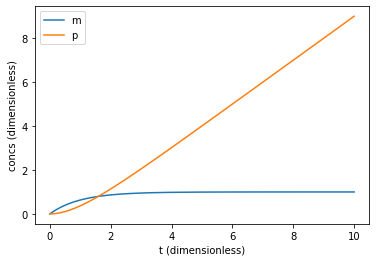

In [3]:
# Implementation

# Define the model's gradient function
def M2(y, t, params):
    m = y[0]
    p = y[1]
    
    k1 = params[0]
    k2 = params[1]
    ka = params[2]
    kb = params[3]
   
    derivs = [
        k1 - k2*m,
        ka*m - kb*p
    ]
    return(derivs)

# Set initial conditions 
m0 = 0.0
p0 = 0.0

# Set parameters
k1 = 1.0
k2 = 1.0
ka = 1.0
kb = 0.0

# Solve
time = np.linspace(0,10,100)
y0 = np.array([m0,p0])
params = np.array([k1,k2,ka,kb])
sol = odeint(M2, y0, time, args=(params,))

# Plot
plt.plot(time,sol[:,0], label='m');
plt.plot(time,sol[:,1], label='p');
plt.xlabel('t (dimensionless)'); plt.ylabel('concs (dimensionless)'); plt.legend(); plt.show()

### 3. Binary mechanistic transcription/translation with degradation

Here both transcription and translation are explictly modelled using the simplest enzyme-catalysed mechanism, that of irreversible catalysis proceeding through a bimolecular intermediate. $d$, $R$, and $r$ represent concentrations of DNA, RNAP, and ribosome respectively. This is a simplified representation of the actual mechanism, which proceeds through many more steps: for instance, mRNA and protein synthesis are polymerisation reactions which contain initiation, elongation, and termination steps, which in this model are simplified into one catalytic rate constant ($k_3$ for transcription, and $k_c$ for translation.)

Qualitatively this can look similar to the previous simpler model; however the behaviour is dependent on the values of the internal parameters, which must be estimated from experimental measurements. Typically, the binding rates of RNAP to DNA, and mRNA to ribosome, are faster than the catalytic step.

*Mechanism*

\begin{equation}
d + R \underset{k_{2}}{\stackrel{k_1}{\rightleftharpoons}} [Rd] \overset{k_3}\rightarrow m + d + R
\end{equation}
\begin{equation}
m + r \underset{k_{b}}{\stackrel{k_a}{\rightleftharpoons}} [rm] \overset{k_c}\rightarrow p + m + r
\end{equation}

\begin{equation}
m \overset{k_4}\rightarrow \emptyset
\end{equation}
\begin{equation}
p \overset{k_d}\rightarrow \emptyset
\end{equation}

*ODEs*    
                
\begin{align}
\dot{d} &= -k_1dR + k_2 [Rd] + k_3 [Rd] \\
\dot{R} &= -k_1dR + k_2 [Rd] + k_3 [Rd] \\
\dot{[Rd]} &= k_1dR - k_2 [Rd] - k_3 [Rd] \\
\dot{m} &= k_3 [Rd] -k_amr + k_b [rm] + k_c [rm]- k_4m \\
\dot{r} &= -k_amr + k_b [rm] + k_c [rm]\\
\dot{[rm]} &= k_amr - k_b [rm] - k_c [rm] \\
\dot{p} &= k_c[rm] - k_dp
\end{align}

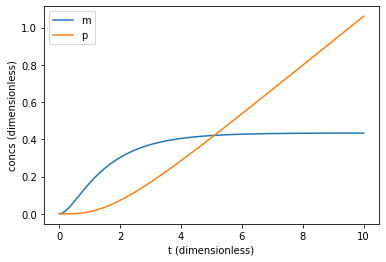

In [4]:
# Implementation

# Define the model's gradient function
def M3(y, t, params):
    d = y[0]
    R = y[1]
    Rd = y[2]
    m = y[3]
    r = y[4]
    rm = y[5]
    p = y[6]
    
    k1 = params[0]
    k2 = params[1]
    k3 = params[2]
    k4 = params[3]
    ka = params[4]
    kb = params[5]
    kc = params[6]
    kd = params[7]
   
    derivs = [
        -k1*d*r + k2*Rd + k3*Rd,
        -k1*d*r + k2*Rd + k3*Rd,
        k1*d*r - k2*Rd - k3*Rd,
        k3*Rd - ka*m*r + kb*rm + kc*rm - k4*m,
        -ka*m*r + kb*rm + kc*rm,
        ka*m*r - kb*rm - kc*rm,
        kc*rm - kd*p 
    ]
    return(derivs)

# Set initial condition
d0 = 1.0
R0 = 1.0
Rd0 = 0.0
m0 = 0.0
r0 = 1.0
rm0 = 0.0
p0 = 0.0

# Set parameters
k1 = 1.0
k2 = 1.0
k3 = 1.0
k4 = 1.0
ka = 1.0
kb = 1.0
kc = 1.0
kd = 0.0

# Solve
time = np.linspace(0,10,100)
y0 = np.array([d0,R0,Rd0,m0,r0,rm0,p0])
params = np.array([k1,k2,k3,k4,ka,kb,kc,kd])
sol = odeint(M3, y0, time, args=(params,))

# Plot
plt.plot(time,sol[:,3]+sol[:,5], label='m');
plt.plot(time,sol[:,6], label='p');
plt.xlabel('t (dimensionless)'); plt.ylabel('concs (dimensionless)'); plt.legend(); plt.show()

### 4. Binary mechanistic transcription/translation with termination

Cell-free reactions terminate after a few hours. This can be due to substrate depletion, enzymatic inactivation, or loss of homeostasis. In this model we represent the process using an exponential decay of the catalytic rate constants. The qualitative behaviour observed is a saturation of protein concentration, and a peaked mRNA profile. These features are observed in experimental plate reader traces, and so this model is the first one which captures qualitative experimental observations.

*Mechanism*

\begin{equation}
d + R \underset{k_{2}}{\stackrel{k_1}{\rightleftharpoons}} [Rd] \overset{k_3}\rightarrow m + d + R
\end{equation}
\begin{equation}
m + r \underset{k_{b}}{\stackrel{k_a}{\rightleftharpoons}} [rm] \overset{k_c}\rightarrow p + m + r
\end{equation}
\begin{equation}
m \overset{k_4}\rightarrow \emptyset
\end{equation}
\begin{equation}
p \overset{k_d}\rightarrow \emptyset
\end{equation}
\begin{equation}
k_3 \overset{\lambda}\rightarrow 0
\end{equation}
\begin{equation}
k_c \overset{\lambda}\rightarrow 0
\end{equation}


*ODEs*    
                
\begin{align}
\dot{d} &= -k_1dR + k_2 [Rd] + k_3(t) [Rd] \\
\dot{R} &= -k_1dR + k_2 [Rd] + k_3(t) [Rd] \\
\dot{[Rd]} &= k_1dR - k_2 [Rd] - k_3(t) [Rd] \\
\dot{m} &= k_3(t) [Rd] -k_amr + k_b [rm] + k_c(t) [rm]- k_4m \\
\dot{r} &= -k_amr + k_b [rm] + k_c(t) [rm]\\
\dot{[rm]} &= k_amr - k_b [rm] - k_c(t) [rm] \\
\dot{p} &= k_c(t)[rm] - k_dp
\end{align}

\begin{align}
k_3(t) &= k_3 \exp(-\lambda t) \\
k_c(t) &= k_c \exp(-\lambda t)
\end{align}

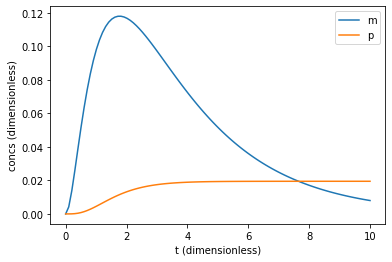

In [5]:
# Implementation

# Define the model's gradient function
def M4(y, t, params):
    d = y[0]
    R = y[1]
    Rd = y[2]
    m = y[3]
    r = y[4]
    rm = y[5]
    p = y[6]
    k3 = y[7]
    kc = y[8]
    
    k1 = params[0]
    k2 = params[1]
    k4 = params[2]
    ka = params[3]
    kb = params[4]
    kd = params[5]
    lamb = params[6]
   
    derivs = [
        -k1*d*r + k2*Rd + k3*Rd,
        -k1*d*r + k2*Rd + k3*Rd,
        k1*d*r - k2*Rd - k3*Rd,
        k3*Rd - ka*m*r + kb*rm + kc*rm - k4*m,
        -ka*m*r + kb*rm + kc*rm,
        ka*m*r - kb*rm - kc*rm,
        kc*rm - kd*p,
        -lamb*k3,
        -lamb*kc
    ]
    return(derivs)

# Set initial condition
d0 = 1.0
R0 = 1.0
Rd0 = 0.0
m0 = 0.0
r0 = 1.0
rm0 = 0.0
p0 = 0.0
k3 = 1.0
kc = 1.0

# Set parameters
k1 = 1.0
k2 = 1.0
k4 = 1.0
ka = 1.0
kb = 1.0
kd = 0.0
lamb = 1.0

# Solve
time = np.linspace(0,10,100)
y0 = np.array([d0,R0,Rd0,m0,r0,rm0,p0,k3,kc])
params = np.array([k1,k2,k4,ka,kb,kd,lamb])
sol = odeint(M4, y0, time, args=(params,))

# Plot
plt.plot(time,sol[:,3]+sol[:,5], label='m');
plt.plot(time,sol[:,6], label='p');
plt.xlabel('t (dimensionless)'); plt.ylabel('concs (dimensionless)'); plt.legend(); plt.show()

### 5. Quasi steady-state transcription/translation with termination

In order to extend the above model to account for multiple species, for instance for more than one gene, kinetic equations have to be added for for every mechanism. This is possible but laborious to do by hand, or can be automated using chemical kinetics simulators such as Tellurium (https://github.com/sys-bio/tellurium). An alternative way is to apply a quasi steady state approximation, where the binding reactions are considered much faster than the catalytic reactions. This allows the model to be reduced to a simpler format, with the steady-state concentrations of all bimolecular complexes approximated by algebraic equations. However, the ODEs have to be solved in parallel with the algebraic constraints, leading to a system of equations known as DAEs, or differential-algebraic equations. This is not possible to solve with Python using standard packages, but can be easily solved in Julia.

*Mechanism*

\begin{equation}
\emptyset \overset{k_3(t)[Rd]_{ss}}\rightarrow m
\end{equation}
\begin{equation}
\emptyset \overset{k_c(t)[rm]_{ss}}\rightarrow p
\end{equation}
\begin{equation}
m \overset{k_4}\rightarrow \emptyset
\end{equation}
\begin{equation}
p \overset{k_d}\rightarrow \emptyset
\end{equation}
\begin{equation}
k_3 \overset{\lambda}\rightarrow 0
\end{equation}
\begin{equation}
k_c \overset{\lambda}\rightarrow 0
\end{equation}


*DAEs*    
 
Differential equations:
\begin{align}
\dot{m} &= k_3(t) [Rd]_{ss} - k_4m \\
\dot{p} &= k_c(t) [rm]_{ss} - k_dp
\end{align}

Algebraic equations:
\begin{align}
[Rd]_{ss} &= \frac{1}{2} \left[f_{TX} - \sqrt{f_{TX}^2-4R_0d_0} \right] \\
[rm]_{ss} &= \frac{1}{2} \left[f_{TL} - \sqrt{f_{TL}^2-4r_0 m} \right] \\
f_{TX} &= {R_0 + d_0 + K_{TX}} \\
f_{TL} &= (r_0 + m + K_{TL})
\end{align}

Rate and saturation constants:
\begin{align}
k_3(t) &= k_3 \exp(-\lambda t) \\
k_c(t) &= k_c \exp(-\lambda t) \\
K_{TX} &= \frac{k_2+k_3}{k_1} \\
K_{TL} &= \frac{k_b+k_c}{k_a}
\end{align}

### 6. Condition-dependent termination (Stogbauer et al. 2012)

This model has a more sophisticated description of reaction termination. Whereas in earlier examples we used simple exponential decay of catalytic rates, in this model the rates are kept constant, while the enzymatic species $E_{TX}$ and $E_{TL}$, representing transcriptional and translational enzyme concentrations respectively, degrade at a rate which depends on conditions within the reaction. In particular, the degradation of transcriptional rate is dependent on the DNA concentration. Below we implement the model using parameters from the original paper, and so the results are in physical units.

Reference: https://doi.org/10.1039/c2ib00102k

*Mechanism*

\begin{equation}
\emptyset \overset{k_3 E_{TX} d/(K_{TX}+d)}\rightarrow m
\end{equation}
\begin{equation}
\emptyset \overset{k_c E_{TX} m/(K_{TL}+m)}\rightarrow p
\end{equation}
\begin{equation}
m \overset{k_4}\rightarrow \emptyset
\end{equation}

\begin{equation}
E_{TX} \overset{\lambda_1}\rightarrow 0
\end{equation}
\begin{equation}
E_{TL} \overset{\lambda_2}\rightarrow 0
\end{equation}

\begin{align}
\dot{m}&=k_{3} E_{TX} \frac{d}{K_{TX}+d} - k_4 m \\
\dot{p}&=k_{c} E_{TL} \frac{m}{K_{TL}+m} \\
\dot{E_{TX}}&=-\lambda_1 E_{TX}\frac{d}{K_{TX}+d} \\
\dot{E_{TL}}&=-\lambda_2\frac{E_{TL}}{K_{ETL}+E_{TL}}
\end{align}

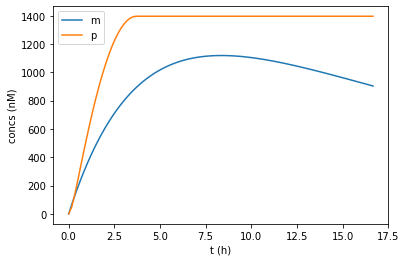

In [6]:
# Implementation

# Define the model's gradient function
def M6(y, t, params):
    m = y[0]
    p = y[1]
    ETX = y[2]
    ETL = y[3]
    
    k3 = params[0]
    k4 = params[1]
    kc = params[2]
    lamb1 = params[3]
    lamb2 = params[4]
    KTX = params[5]
    KTL = params[6]
    KETL = params[7]
    d = params[8]
   
    derivs = [
        k3*ETX*d/(KTX+d) - k4*m,
        kc*ETL*m/(KTL+m),
        -lamb1*ETX*d/(KTX+d),
        -lamb2*ETL/(KETL+ETL)
    ]
    return(derivs)

# Set initial condition

m0 = 0.0
p0 = 0.0
ETX0 = 1.0
ETL0 = 1.0

# Set parameters
k3 = 18.2 # nM/min = 2.2 NTP/s
k4 = 7.8e-4 # min^-1
kc = 16.1 # nM/min = 0.03 aa/s
lamb1 = 1.1e-2 # min^-1
lamb2 = 4.5e-3 # min^-1
KTX = 8.5 # nM
KTL = 65.8 # nM
KETL = 6e-5
d = 5

# Solve
time = np.linspace(0,1000,100)
y0 = np.array([m0,p0,ETX0,ETL0])
params = np.array([k3,k4,kc,lamb1,lamb2,KTX,KTL,KETL,d])
sol = odeint(M6, y0, time, args=(params,))

# Plot
plt.plot(time/60,sol[:,0], label='m');
plt.plot(time/60,sol[:,1], label='p');
plt.xlabel('t (h)'); plt.ylabel('concs (nM)'); plt.legend(); plt.show()

### 7. Explicit resource consumption: TXTL toolbox (Tuza et al. 2015)

This model explicitly models resource consumption, by simulating a single lumped NTP species $x_5$ which is consumed by transcription, and a single lumped aminoacyl-tRNA species $x_6$ consumed by translation. These species are also subject to degradation. The model mechanistically describes the intermediate steps in transcription (but not translation), and thus is more fine-grained than earlier models. 

This model forms the basis of the TXTL toolbox from the Murray and Noireaux labs, originally written in Matlab (https://github.com/BuildACell/txtlsim) but slowly being ported to Python (https://github.com/BuildACell/txtlsim-python). 
 
Reference: https://doi.org/10.1109/ECC.2015.7330760

*Mechanism*

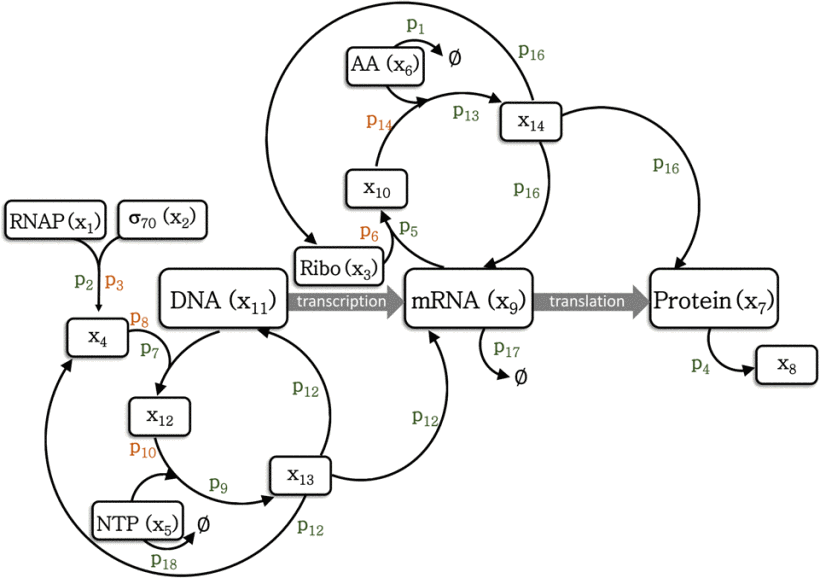

In [7]:
display(Image(filename='img/tuza_mech.png', width="400", embed=True))

*ODEs*

\begin{align}
\dot{x_1}&=-F_1 \\
\dot{x_2}&=-F_1 \\
\dot{x_3}&=-F_3+F_{10} \\
\dot{x_4}&=F_1-F_4+F_7 \\
\dot{x_5}&=-F_5-F_{12} \\
\dot{x_6}&=-F_8-F_{13} \\
\dot{x_7}&=-F_2+F_{10} \\
\dot{x_8}&=F_2 \\
\dot{x_9}&=-F_3+F_7+F_{10}-F_{11} \\
\dot{x_10}&=F_3-F_8+F_9 \\
\dot{x_11}&=-F_4+F_7 \\
\dot{x_12}&=F_4-F_5+F_6 \\
\dot{x_13}&=F_5-F_6-F_7 \\
\dot{x_14}&=F_8-F_9-F_{10} 
\end{align}

\begin{align}
F_{1}&= p_2x_1x_2 - p_3x_4\\
F_{2}&= p_4x_7\\
F_{3}&= p_5x_9x_3-p_6x_{10}\\
F_{4}&= p_7x_{11}x_4-p_8x_{12}\\
F_{5}&= p_9x_{12}x_5 - p_{10}x_{13}\\
F_{6}&= p_{11}x_{13}\\
F_{7}&= p_{12}x_{13}\\
F_{8}&= p_{13}x_{13}x_6-p_{14}x_{14}\\
F_{9}&= p_{15}x_{14}\\
F_{10}&= p_{16}x_{14}\\
F_{11}&= p_{17}x_9\\
F_{12}&= p_{18}x_5\\
F_{13}&= p_1x_6 
\end{align}

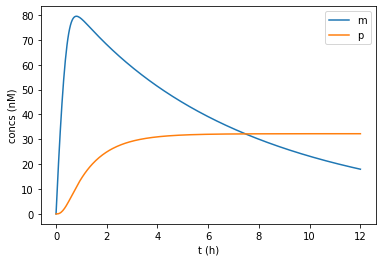

In [8]:
# Implementation

# Define the model's gradient function
def M7(x, t, params):
    x1=x[0]
    x2=x[1]
    x3=x[2]
    x4=x[3]
    x5=x[4]
    x6=x[5]
    x7=x[6]
    x8=x[7]
    x9=x[8]
    x10=x[9]
    x11=x[10]
    x12=x[11]
    x13=x[12]
    x14=x[13]
    
    p1=params[0]
    p2=params[1]
    p3=params[2]
    p4=params[3]
    p5=params[4]
    p6=params[5]
    p7=params[6]
    p8=params[7]
    p9=params[8]
    p10=params[9]
    p11=params[10]
    p12=params[11]
    p13=params[12]
    p14=params[13]
    p15=params[14]
    p16=params[15]
    p17=params[16]
    p18=params[17]
   
    F1=0 # SSA p2*x1*x2-p3*x4
    F2=p4*x7
    F3=p5*x9*x3-p6*x10
    F4=p7*x11*x4-p8*x12
    F5=p9*x12*x5-p10*x13
    F6=p11*x13
    F7=p12*x13
    F8=p13*x10*x6-p14*x14
    F9=p15*x14
    F10=p16*x14
    F11=p17*x9
    F12=p18*x5
    F13=p1*x6
    
    derivs=[
        -F1,
        -F1,
        -F3+F10,
        F1-F4+F7,
        -F5-F12,
        -F8-F13,
        -F2+F10,
        F2,
        -F3+F7+F10-F11,
        F3-F8+F9,
        -F4+F7,
        F4-F5+F6,
        F5-F6-F7,
        F8-F9-F10
    ]
    
    return(derivs)

# Set initial condition
x1_0=100 # nM RNAP
x2_0=35 # nM s70
x3_0=375.58 # nM ribo
x4_0=276.13 # nM Rs
x5_0=1200 # nM NTP 
x6_0=1500 # nM AA
x7_0=0
x8_0=0
x9_0=0
x10_0=0
x11_0=10 #10 nM DNA
x12_0=0
x13_0=0
x14_0=0

# Set parameters
b=1/100*(1000)
p1=1.9e-4 #1/s
p2=0 # not used
p3=0 # not used
p4=1/6/60 #/s maturation rate measured
p5=6.94e-2 #1/(s.nM)
p6=8.43e-1 #1/s
p7=7e-3 #1/(s.nM)
p8=1.38e2 #1/s
p9=6.2e-2 #1/(s.nM)
p10=3.55e-1 #1/s
p11=(b-1)*8.9e-3 #1/s AUX RXN
p12=8.9e-3 #1/s
p13=5.95e-2 #1/(s.nM)
p14=2.33e5 #1/s
p15=b/3*3.02e-1 #1/s AUX RXN
p16=3.02e-1 #1/s
p17=1.07e-3 #1/s mRNA degradation restricted
p18=2.98e-4 #1/s

# Solve
time = np.linspace(0,12*60*60,361) # 12 hours
y0 = np.array([x1_0,x2_0,x3_0,x4_0,x5_0,x6_0,x7_0,x8_0,x9_0,x10_0,x11_0,x12_0,x13_0,x14_0])
params = np.array([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18])
sol = odeint(M7, y0, time, args=(params,))

# Plot
plt.plot(time/3600,sol[:,8]+sol[:,9]+sol[:,13], label='m');
plt.plot(time/3600,sol[:,7], label='p');
plt.xlabel('t (h)'); plt.ylabel('concs (nM)'); plt.legend(); plt.show()

### 8. PURE system model (Mavelli et al. 2015)

This model is a good example of an integrated cell-free model which takes combines cell-free protein synthesis with a basic metabolism. It does this by separating the PURE system into its four functional components: transcription, translation, aminoacylation of tRNA, and energy regeneration. It describes the enzymatic steps for each process using 'multiple saturation kinetics', or a production of Michaelis-Menten-like terms. 

Reference: https://doi.org/10.1007/s11538-015-0082-8

*Mechanism*


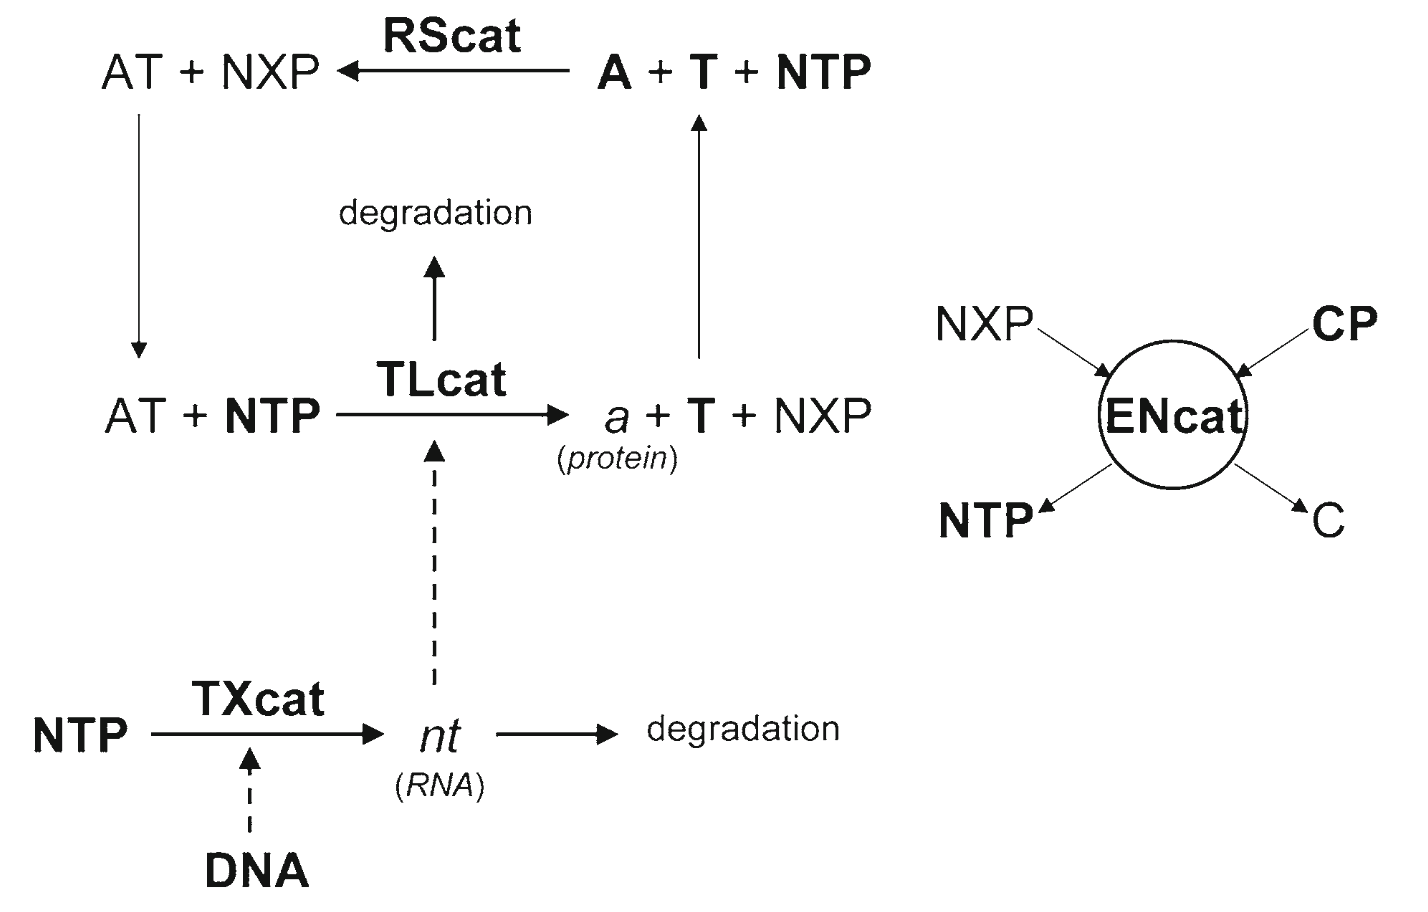

In [9]:
display(Image(filename='img/mavelli.png', width="400", embed=True))

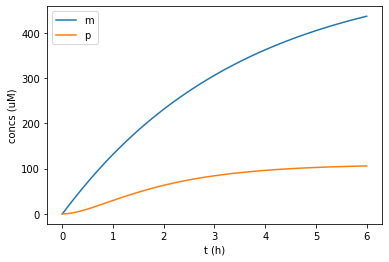

In [10]:
# Implementation

# Define helper Hill function
def MM(c,K):
    return(c/(K+c))

# Define the model's gradient function
def M8(y, t, params):
    NTP = y[0]
    NXP = y[1]
    nt = y[2]
    Ppi = y[3]
    ATr = y[4]
    a = y[5]
    T = y[6]
    A = y[7]
    CP = y[8]  
    C = y[9]
    CTL = y[10]

    
    d = params[0]
    CTX = params[1]
    CRS = params[2]
    CEN = params[3]    
    kTX = params[4]
    kTL = params[5]
    kRS = params[6]
    kEN = params[7]
    kntdeg = params[8]
    kTLdeg = params[9]
    Ktxd = params[10]
    KtxN = params[11]
    Ktln = params[12]
    Ktla = params[13]
    KtlNt = params[14]
    KrsA = params[15]
    Krst = params[16]
    KrsN = params[17]
    Kenc = params[18]
    KenN = params[19]
    nT = params[20]
    nA = params[21]

    VTX = kTX*CTX*MM(d,Ktxd)*MM(NTP,KtxN)
    VTL = kTL*CTL*MM(nt,Ktln)*MM(nT/nA*ATr,Ktla)*MM(NTP,KtlNt)
    VRS = kRS*CRS*MM(A,KrsA)*MM(nT/nA*T,Krst)*MM(NTP,KrsN)
    VEN = kEN*CEN*MM(CP,Kenc)*MM(NXP,KenN)
    
    derivs = [
        -VTX - 2*VTL -VRS + VEN,
        2*VTL + VRS + VEN,
        VTX - kntdeg*nt,
        VTX,
        -VTL + VRS,
        VTL ,
        VTL - VRS,
        -VRS,
        -VEN,
        VEN,
        -kTLdeg*CTL
    ]
    return(derivs)

# Set initial conditions 
NTP = 1500 # uM
NXP = 0 # uM
nt = 0 # uM
Ppi = 0 # uM
ATr = 0 # uM
a = 0 # uM
T = 1.9 # uM
A = 300 # uM
CP = 20000 # uM
C = 0 # uM
CTL = 2.2 # uM

# Set parameters
d = 1.7e-3 # uM
CTX = 0.1 
CRS = 0.16
CEN = 0.08    
kTX = 1.67 # s^-1
kTL = 0.085 # s^-1
kRS = 6.2 # s^-1
kEN = 100 # s^-1
kntdeg = 7.92e-5 # s^-1
kTLdeg = 1.86e-4 # s^-1
Ktxd = 5e-3 # uM 
KtxN = 80 # uM
Ktln = 226 # uM
Ktla = 10 # uM
KtlNt = 10 # uM
KrsA = 23 # uM
Krst = 0.7 # uM
KrsN = 200 # uM
Kenc = 200 # uM
KenN = 40 # uM
nT = 46
nA = 20

# Solve

time=np.linspace(0,6*60*60,61)
y0 = np.array([NTP,NXP,nt,Ppi,ATr,a,T,A,CP,C,CTL])
params = np.array([d,CTX,CRS,CEN,kTX,kTL,kRS,kEN,
                  kntdeg,kTLdeg,Ktxd,KtxN,Ktln,Ktla,
                  KtlNt,KrsA,Krst,KrsN,Kenc,KenN,nT,nA])
sol = odeint(M8, y0, time, args=(params,),mxstep=10000000)

# Plot
plt.plot(time/3600,sol[:,2], label='m');
plt.plot(time/3600,sol[:,5], label='p');
plt.xlabel('t (h)'); plt.ylabel('concs (uM)'); plt.legend(); plt.show()

### Other models to do:

Recent relevent models have focused on translation. 

PURE system
* Doerr et al. 2019 - mechanistic translation model (https://doi.org/10.1088/1478-3975/aaf33d)

Lysate
* Nieß et al. 2017 - mechanistic translation model (https://doi.org/10.1021/acssynbio.7b00117)
